<a href="https://colab.research.google.com/github/ppijbb/NLP_study/blob/main/LSTM%2BCRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle competitions list
!kaggle competitions download -c elo-merchant-category-recommendation
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy
!pip install nltk
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*

!pip uninstall keras_contrib
!pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
!sudo pip install seqeval

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Get:1 http://security.

In [ ]:
!sudo pip uninstall keras
!sudo pip install keras==2.3.1

Uninstalling Keras-2.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 378kB 2.8MB/s 


In [ ]:
from __future__ import unicode_literals
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import keras
import re

from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import TensorBoard
from collections import namedtuple

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed, Dropout, Bidirectional, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

%matplotlib inline
%config InlineBackend.figure_format='retina'

Using TensorFlow backend.


In [ ]:
Candidate = namedtuple('Candidate', ['lemma', 'tag', 'is_ps'])

devjson = json.load(open('./NEtaggedCorpus_train.json'))
sentence = devjson.get('sentence')
len(sentence[0].get('morp'))

trancedata = []
temptrance = []
for morp in sentence:
  for lentyp in morp.get('morp'):
    temptrance.append([lentyp.get('lemma'),lentyp.get('type')])
  trancedata.append(temptrance)
  temptrance=[]

print("변환 셈플 수 : ", len(trancedata))
print(trancedata[0])

samplemorp, sampletags = [], [] 
for trancedataT in trancedata: # 14,041개의 문장 샘플을 1개씩 불러온다.
    samplemorpT, sampletagsT = zip(*trancedataT) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    samplemorp.append(list(samplemorpT)) # 각 샘플에서 단어 정보만 저장한다.
    sampletags.append(list(sampletagsT)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

변환 셈플 수 :  3555
[['한편', 'NNG'], [',', 'SP'], ['AFC', 'SL'], ['챔피언스', 'NNG'], ['리그', 'NNG'], ['E', 'SL'], ['조', 'NNG'], ['에', 'JKB'], ['속하', 'VV'], ['ㄴ', 'ETM'], ['포항', 'NNP'], ['역시', 'MAJ'], ['대회', 'NNG'], ['8강', 'NNG'], ['진출', 'NNG'], ['이', 'JKS'], ['불투명', 'NNG'], ['하', 'VV'], ['다', 'EC'], ['.', 'SF']]


샘플의 최대 길이 : 168
샘플의 평균 길이 : 34.038819


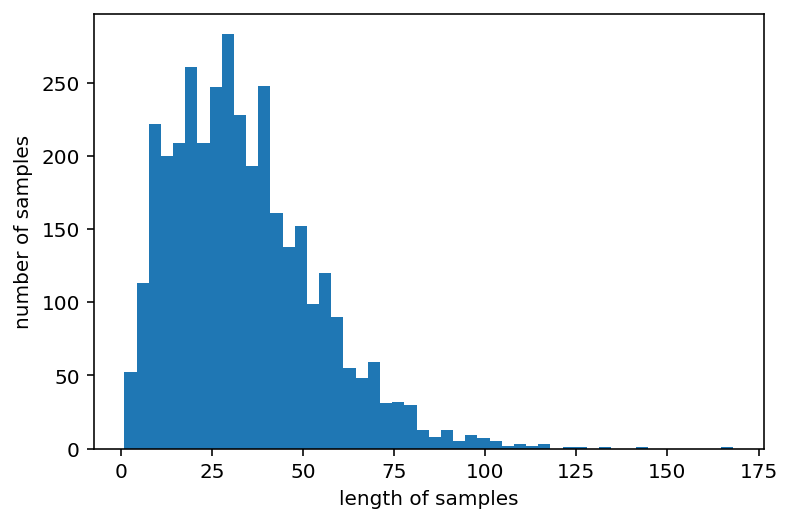

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in samplemorp))
print('샘플의 평균 길이 : %f' % (sum(map(len, samplemorp))/len(samplemorp)))
plt.hist([len(s) for s in samplemorp], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_words = 100000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(samplemorp)
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(sampletags)

vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 100000
개체명 태깅 정보 집합의 크기 : 46


In [ ]:
X_train = src_tokenizer.texts_to_sequences(samplemorp)
y_train = tar_tokenizer.texts_to_sequences(sampletags)
print(X_train[0])
print(y_train[0])

[183, 11, 4276, 884, 162, 931, 402, 10, 2608, 7, 1516, 608, 145, 1361, 414, 4, 6347, 2, 8, 3]
[1, 16, 19, 1, 1, 19, 1, 6, 3, 7, 4, 33, 1, 1, 1, 15, 1, 3, 2, 11]


In [ ]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(samplemorp[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['한편', ',', 'AFC', '챔피언스', '리그', 'E', '조', '에', '속하', 'ㄴ', '포항', '역시', '대회', '8강', '진출', '이', '불투명', '하', '다', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['한편', ',', 'afc', '챔피언스', '리그', 'e', '조', '에', '속하', 'ㄴ', '포항', '역시', '대회', '8강', '진출', '이', '불투명', '하', '다', '.']


In [ ]:
max_len = 130
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (2844, 130)
훈련 샘플 레이블의 크기 : (2844, 130, 46)
테스트 샘플 문장의 크기 : (711, 130)
테스트 샘플 레이블의 크기 : (711, 130, 46)


In [ ]:
from keras_contrib.layers import *
#from keras_contrib.losses import crf_loss
#from keras_contrib.metrics import crf_viterbi_accuracy
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=max_len)) #mask_zero=True를 제거해야 실행이 됨
model.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.3)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)

In [ ]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit(X_train, y_train, batch_size=36, epochs=30, validation_split=0.2, verbose=1) #30번째에서 98%가까이 수준유지

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Train on 2275 samples, validate on 569 samples
Epoch 1/30
2275/2275 [==============================] - 23s 10ms/step - loss: 1.2349 - crf_viterbi_accuracy: 0.7336 - val_loss: 0.7699 - val_crf_viterbi_accuracy: 0.8144
Epoch 2/30
2275/2275 [==============================] - 22s 10ms/step - loss: 0.7290 - crf_viterbi_accuracy: 0.8160 - val_loss: 0.6754 - val_crf_viterbi_accuracy: 0.8188
Epoch 3/30
2275/2275 [==============================] - 22s 10ms/step - loss: 0.6415 - crf_viterbi_accuracy: 0.8199 - val_loss: 0.5668 - val_crf_viterbi_accuracy: 0.8341
Epoch 4/30
2275/2275 [==============================] - 22s 10ms/step - loss: 0.5031 - crf_viterbi_accuracy: 0.8485 - val_loss: 0.4280 - val_crf_viterbi_accuracy: 0.8726
Epoch 5/30
2275/2275 [==============================] - 22s 10ms/step - loss: 0.3979 - crf_viterbi_accuracy: 0.8781 - val_loss: 0.3446 - val_crf_viterbi_accuracy: 0.8929
Epoch 6/30
2275/2275 [==============================] - 22s 10ms/step - loss: 0.3199 - crf_viterbi_accu

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test))[1])

711/711 [==============================] - 3s 4ms/step

 테스트 정확도: 0.9791


In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_tag를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index + 1]) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict(X_test)
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print(classification_report(test_tags, pred_tags))
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

           precision    recall  f1-score   support

      nnp       0.92      0.92      0.92      1300
       jx       0.89      0.96      0.93       758
       ec       0.82      0.87      0.84      4859
      jkb       1.00      0.91      0.95      1197
      vcp       0.91      0.94      0.93       304
       sf       0.97      0.98      0.97       792
      nng       1.00      1.00      1.00       710
       sp       0.94      0.99      0.96       483
       sn       0.76      0.56      0.65      1168
       vv       0.98      0.86      0.91      1385
      etm       0.98      0.95      0.97      1089
       jc       0.77      0.89      0.82       115
      nnb       0.98      0.98      0.98      1118
      xsv       1.00      1.00      1.00       732
       ep       0.94      0.96      0.95       708
       ss       0.99      1.00      1.00       851
       nr       0.59      0.86      0.70        77
      etn       1.00      0.95      0.97        92
      jks       1.00      1.00

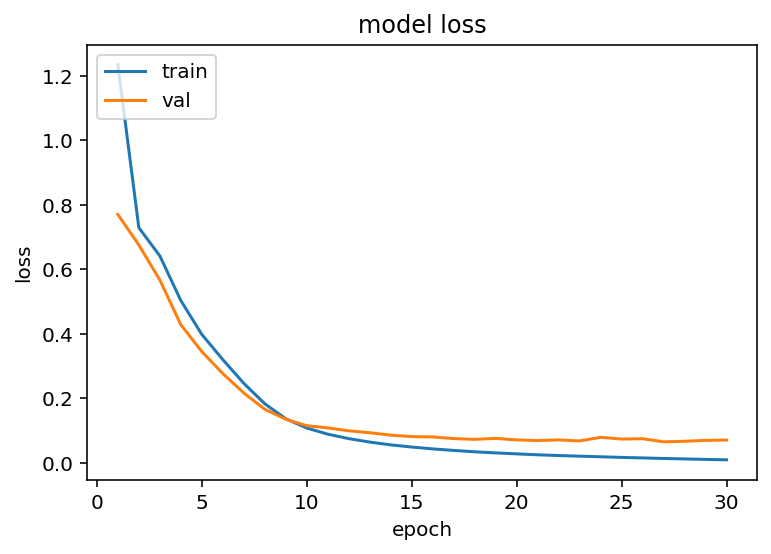

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
word_to_index = src_tokenizer.word_index # 실험 문장 1
new_sentence='황 대표는 이날 열린 당 4·15 총선 중앙선거대책위원회 첫 회의에서 "최근 우리 당과 미래한국당에서 몇 가지 씁쓸한 뉴스를 접했을 것"라며 이렇게 말했다.'.split()
print(new_sentence)

['황', '대표는', '이날', '열린', '당', '4·15', '총선', '중앙선거대책위원회', '첫', '회의에서', '"최근', '우리', '당과', '미래한국당에서', '몇', '가지', '씁쓸한', '뉴스를', '접했을', '것"라며', '이렇게', '말했다.']


In [ ]:
word_to_index = src_tokenizer.word_index # 실험 문장 2
new_sentence='이런 가운데 오늘은 한발 더 나아가 도쿄올림픽이 1년 될거라는 IOC 위원의 인터뷰도 나왔네요.'.split()
print(new_sentence)

['이런', '가운데', '오늘은', '한발', '더', '나아가', '도쿄올림픽이', '1년', '될거라는', 'IOC', '위원의', '인터뷰도', '나왔네요.']


In [ ]:
new_X=[]
for w in new_sentence:
    try:
      new_X.append(word_to_index.get(w,1))
    except KeyError:
      new_X.append(word_to_index['OOV'])
      # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩
      
pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)

In [ ]:
p = model.predict(np.array([pad_new[0]]))
p = np.argmax(p, axis=-1)
print("{:25}||{}".format("단어", "예측값"))
print(50 * "=")
for w, pred in zip(new_sentence, p[0]):
    print("{:25}: {:3}".format(w, index_to_ner[pred].upper()))

단어                       ||예측값
이런                       : MM 
가운데                      : NNG
오늘은                      : NNG
한발                       : MAG
더                        : MAG
나아가                      : NNG
도쿄올림픽이                   : NNG
1년                       : NNG
될거라는                     : NNG
IOC                      : NNG
위원의                      : NNG
인터뷰도                     : NNG
나왔네요.                    : NNG


학습데이터

https://ithub.korean.go.kr/user/total/referenceView.do;jsessionid=D7517E6D274D8CBA2B07A97EE258BE00

참고 
  
  https://wikidocs.net/34156
  
  https://keep-steady.tistory.com/20
